# Boulder, Colorado Urban Greenspace

Boulder, Colorado is a city in the foothills of the Front Range of the Rocky Mountains in the U.S. state of Colorado. It has a semi-arid climate with cold winters and warm, relatively wet summers. The City has been considered a leader in urban forestry being named a Tree City USA by the National Arbor Day Foundation since 1984 [1]. The city maintains a street tree inventory. In 2018, the City of Boulder released the Urban Forest Strategic Plan and in 2023, the City issued a State of the Urban Forest Report [2]. The Strategic Plan outlines a goal to maintain the city's tree canopy at 16% (a no-net-loss goal) given ongoing declines in the tree canopy due to the emerald ash borer.

In this notebook, I examined greenspace across the City of Boulder by census tract and conducted a linear regression analysis to test if median annual income correlates with the fraction of greenspace.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/7e/BoulderBearPeak.jpg" alt="Image of Boulder, Colorado" width="400">

> Sources:
>
> [1] https://bouldercolorado.gov/government/departments/forestry/about#main-content
>
> [2] https://storymaps.arcgis.com/stories/0cb784ee805144428f914f904a0bb367

## STEP 1: Set up your analysis

In [4]:
import cartopy.crs as ccrs
from census import Census
import earthpy as et
import geoviews as gv
import geopandas as gpd
import getpass

import hvplot
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

import io

import matplotlib.pyplot as plt
import numpy as np
import os

import pystac_client
import pandas as pd

import requests
import rioxarray as rxr
from rioxarray.merge import merge_arrays


import shapely

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import us

import xarray as xr

In [2]:
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'boulder-greenspace')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)


In [34]:
%%bash
ls ~/earth-analytics/data/boulder-greenspace

city_boundary.geojson
colorado_census_tracts.geojson


In [22]:
# Download City of Boulder boundary

boundary_url = ("https://gis.bouldercolorado.gov/ags_svr1/rest/services/plan/CityLimits/MapServer/0/query?outFields=*&where=1%3D1&f=geojson")

boundary_path = os.path.join(data_dir, 'city_boundary.geojson')

if os.path.exists(boundary_path):

    boundary_gdf = gpd.read_file(boundary_path)
    print("Data is already downloaded.")

else:
    # Mimic web browser
    user_agent = (
        'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
        'Gecko/20100101 Firefox/81.0'
    )

    # Download GEOJSON
    r = requests.get(url=boundary_url, headers={'User-Agent': user_agent})

    # Read GeoJSON data into a GeoDataFrame
    boundary_geojson_data = r.json()

    # Cache
    boundary_gdf = (gpd.GeoDataFrame
                    .from_features(boundary_geojson_data['features'])
                    .to_file(boundary_path, driver="GeoJSON")
                    )
    
    # Read
    boundary_gdf = gpd.read_file(boundary_path)
    print("Data downloaded and loaded.")



Data is already downloaded.


In [20]:
boundary_gdf

,OBJECTID,TYPE,Shape.STArea(),Shape.STLength(),geometry
0,38,City,7.138182e+07,45971.753983,"POLYGON ((-105.20685 40.07559, -105.20685 40.0..."
1,39,City,4.073072e+07,64816.989082,"POLYGON ((-105.17870 40.06914, -105.17836 40.0..."
2,40,City,8.103168e+04,1661.732555,"POLYGON ((-105.21128 40.01726, -105.21138 40.0..."
3,41,City,2.092505e+07,34856.338250,"POLYGON ((-105.26349 40.08020, -105.26687 40.0..."
4,56,City,6.460669e+08,308304.306022,"POLYGON ((-105.22346 39.98856, -105.22360 39.9..."


<Axes: >

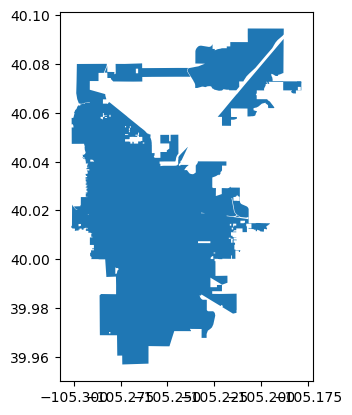

In [24]:
boundary_gdf.to_crs("4326").plot()

In [32]:
# Download census tracts
print(us.states.CO.fips)

colorado_tracts_url = ("https://www2.census.gov/geo/tiger/TIGER2023/"
           "TRACT/tl_2023_08_tract.zip")

colorado_tracts_path = os.path.join(data_dir, 'colorado_census_tracts.geojson')

if os.path.exists(colorado_tracts_path):
    colorado_tracts = gpd.read_file(colorado_tracts_path).to_crs("4326")
    print("Data is already downloaded.")
else:
    gpd.read_file(colorado_tracts_url).to_file(colorado_tracts_path, driver="GeoJSON")
    colorado_tracts_gdf = gpd.read_file(colorado_tracts_path).to_crs("4326")

Data is already downloaded.


<Axes: >

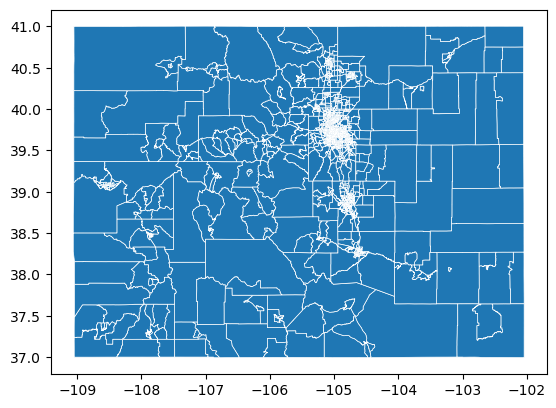

In [33]:
colorado_tracts.plot(edgecolor="white", linewidth=0.5)

EPSG:4326
EPSG:4326


<Axes: >

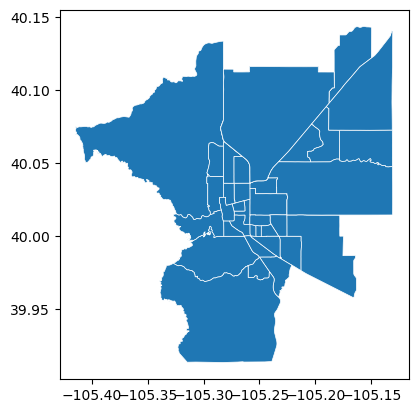

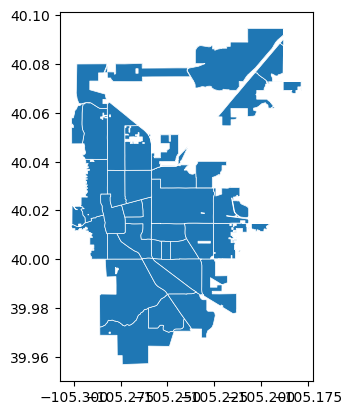

In [41]:
# Select only the census tracts in Boulder
print(colorado_tracts.crs)
print(boundary_gdf.crs)

boulder_tracts_gdf = gpd.sjoin(colorado_tracts, boundary_gdf, how="inner", predicate="intersects")
boulder_tracts_gdf.plot(edgecolor="white", linewidth=0.5)

# Clip to city boundary 
boulder_city_tracts_gdf = gpd.clip(boulder_tracts_gdf, boundary_gdf)
boulder_city_tracts_gdf.plot(edgecolor="white", linewidth=0.5)

In [57]:
# Download census data

# B06011_001E: Estimate!!Median income in the past 12 months --!!Total:	
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/

# Obtain Census variables from the 2019 American Community Survey at the tract level for Illinois (FIPS code: 17)
census_path = os.path.join(data_dir, 'census_data_for_colorado.csv')

if os.path.exists(census_path):
    census_df = pd.read_csv(census_path)
    print("Data is already downloaded.")

else:
    # Authenticate
    api_key = getpass.getpass('U.S. Census API Key')
    c = Census(api_key)
    c

    CO_census = c.acs5.state_county_tract(fields = ('NAME', 'B06011_001E'),
                                      state_fips = '08',
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2021)
    
    tracts_census_df = (pd.DataFrame(CO_census, 
                                     columns=['NAME', 
                                              'B06011_001E', 
                                              'state', 
                                              'county', 
                                              'tract'])
                        .to_csv(census_path, index=False))
    
    census_df = pd.read_csv(census_path)


census_df = census_df.rename(columns={'B06011_001E': 'median_income'})
census_df.head()

# Merge census data with tracts

boulder_city_tracts_gdf

Data is already downloaded.


,NAME,median_income,state,county,tract
0,"Census Tract 78.01, Adams County, Colorado",22984.0,8,1,7801
1,"Census Tract 78.02, Adams County, Colorado",25444.0,8,1,7802
2,"Census Tract 79, Adams County, Colorado",31779.0,8,1,7900
3,"Census Tract 80, Adams County, Colorado",30644.0,8,1,8000
4,"Census Tract 81, Adams County, Colorado",30441.0,8,1,8100


In [66]:
# Merge datasets

boulder_city_tracts_gdf = boulder_city_tracts_gdf.loc[:, ['TRACTCE', 'geometry', 'NAMELSAD']]

boulder_city_tracts_gdf['TRACTCE'] = pd.to_numeric(boulder_city_tracts_gdf['TRACTCE'], errors='coerce')

tracts_w_census_gdf = boulder_city_tracts_gdf.merge(census_df, left_on='TRACTCE', right_on='tract')

negative_or_not = (tracts_w_census_gdf['median_income'] >= 0)

tracts_w_census_gdf = tracts_w_census_gdf[negative_or_not]
tracts_w_census_gdf.head()

,TRACTCE,geometry,NAMELSAD,NAME,median_income,state,county,tract
0,12510,"POLYGON ((-105.28596 39.97229, -105.28587 39.9...",Census Tract 125.10,"Census Tract 125.10, Boulder County, Colorado",74638.0,8,13,12510
1,12509,"POLYGON ((-105.26007 39.98007, -105.25993 39.9...",Census Tract 125.09,"Census Tract 125.09, Boulder County, Colorado",68521.0,8,13,12509
2,12505,"MULTIPOLYGON (((-105.29124 40.00179, -105.2911...",Census Tract 125.05,"Census Tract 125.05, Boulder County, Colorado",83926.0,8,13,12505
3,12609,"POLYGON ((-105.25310 40.00742, -105.25258 40.0...",Census Tract 126.09,"Census Tract 126.09, Boulder County, Colorado",17320.0,8,13,12609
4,12610,"POLYGON ((-105.25835 40.00813, -105.25695 40.0...",Census Tract 126.10,"Census Tract 126.10, Boulder County, Colorado",10366.0,8,13,12610


<Axes: ylabel='Frequency'>

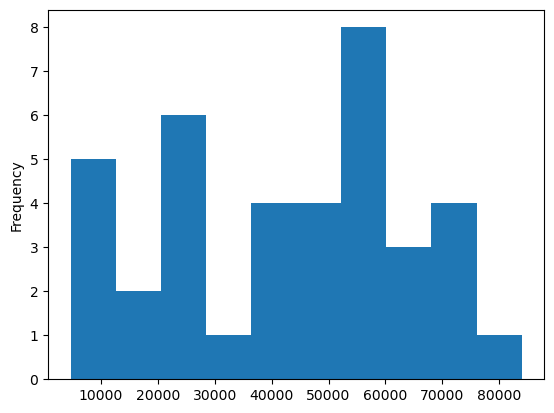

In [72]:
tracts_w_census_gdf['median_income'].plot.hist()

<Axes: >

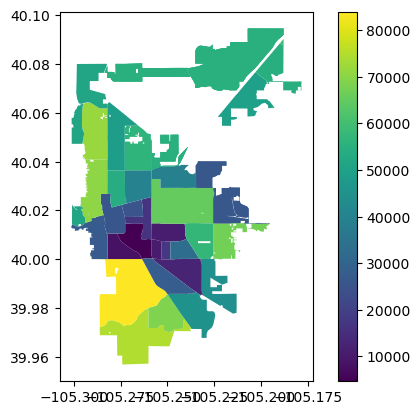

In [73]:
tracts_w_census_gdf.plot('median_income', legend=True)

In [77]:
# Test whether tracts are correctly georeferenced

tracts_basemap_plot = tracts_w_census_gdf.hvplot(geo=True, alpha=0.3, tiles='EsriImagery')
tracts_basemap_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [79]:
# Download data using Microsoft Planetary Computer STAC catalog

# Access catalog
pc_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

pc_catalog.title

'Microsoft Planetary Computer STAC API'

All greenspace stats file exists. Checking which tracts have been downloaded and processed...


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


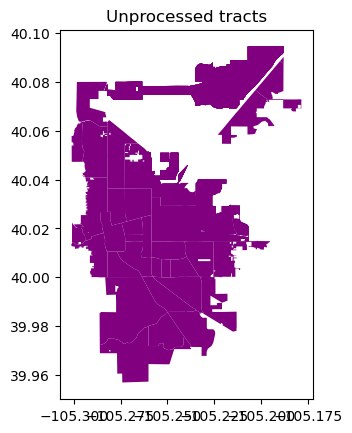

In [82]:
# Check if any data has already been downloaded and processed

all_greenspace_stats_path = os.path.join(data_dir, 'all_greenspace_stats.csv')

if os.path.exists(all_greenspace_stats_path):
    print("All greenspace stats file exists. Checking "
          "which tracts have been downloaded and processed...")

    # Extract tracts to be calculated
    all_tracts = tracts_w_census_gdf['TRACTCE'].astype('int64')

    # Load tracts already processed
    all_greenspace_stats_df = pd.read_csv(all_greenspace_stats_path)

    # Check which values in tract_numbers are not downloaded
    missing_tracts = all_tracts[~all_tracts.isin(all_greenspace_stats_df['tract'])]

    # Create a DataFrame with the missing tracts and their geometries
    tract_geometry = tracts_w_census_gdf[['TRACTCE', 'geometry']]
    tract_geometry['TRACTCE'] = tract_geometry['TRACTCE'].astype('int64')

    missing_tracts_df = pd.DataFrame({'missing_tract': missing_tracts.astype('int64')})

    missing_tracts_merged_df = missing_tracts_df.merge(
        tract_geometry,
        left_on='missing_tract',
        right_on='TRACTCE',
        how='left'
    )

    missing_tracts_gdf = gpd.GeoDataFrame(missing_tracts_merged_df, geometry='geometry')

    missing_tracts_gdf.head()

    # Plot unprocessed tracts
    ax = missing_tracts_gdf.plot(color='purple', label='Unprocessed tracts')

    # Adding title
    plt.title('Unprocessed tracts')

    plt.show()

else:
    all_greenspace_stats_df = pd.DataFrame(columns=['tract', 'fraction_greenspace'])
    all_greenspace_stats_df.to_csv(all_greenspace_stats_path, index=False)

    print("All greenspace stats file does not exist. Created file.")
    


In [83]:
# Compile image URLs for all tracts that are yet to be processed

naip_image_urls_path = os.path.join(data_dir, 'naip_image_urls.csv')
year = 2021
item_url_dfs = []

# Search for image for each tract
for index, tract in missing_tracts_gdf.iterrows():
    # print(tract) 

    tract_name = tract['TRACTCE']

    print(tract_name)

    # Search catalog for image
    tract_geometry = tract['geometry']

    naip_search = pc_catalog.search(
    collections=["naip"],
    intersects=shapely.to_geojson(tract_geometry),
    datetime=f"{year}"
    )

    print(naip_search)

    try:

        for naip_item in naip_search.items():

            print(naip_item.id)
            item_url_dfs.append(
                pd.DataFrame(dict(
                    tract=[tract_name],
                    tile_id=[naip_item.id],
                    url=naip_item.assets['image'].href
                ))
            )
        
    except Exception as e:
        print(f"Error processing item: {str(e)}")
            
        continue


item_url_df = pd.concat(item_url_dfs)
item_url_df

# Save URLS
item_url_df.to_csv(naip_image_urls_path, index=False)

12510
co_m_3910507_nw_13_060_20210727
co_m_3910506_ne_13_060_20210727
12509
co_m_3910507_nw_13_060_20210727
co_m_3910506_ne_13_060_20210727
12505
co_m_3910507_nw_13_060_20210727
co_m_3910506_ne_13_060_20210727
co_m_4010562_se_13_060_20210726
12609
co_m_4010563_sw_13_060_20210727
co_m_3910507_nw_13_060_20210727
co_m_3910506_ne_13_060_20210727
co_m_4010562_se_13_060_20210726
12610
co_m_3910506_ne_13_060_20210727
co_m_4010562_se_13_060_20210726
12401
co_m_3910506_ne_13_060_20210727
co_m_4010562_se_13_060_20210726
12300
co_m_3910506_ne_13_060_20210727
co_m_4010562_se_13_060_20210726
12201
co_m_3910506_ne_13_060_20210727
co_m_4010562_se_13_060_20210726
12605
co_m_4010563_sw_13_060_20210727
co_m_4010562_se_13_060_20210726
12206
co_m_4010562_se_13_060_20210726
12508
co_m_3910507_nw_13_060_20210727
co_m_3910506_ne_13_060_20210727
12710
co_m_4010563_sw_13_060_20210727
co_m_3910507_nw_13_060_20210727
12501
co_m_4010563_sw_13_060_20210727
co_m_3910507_nw_13_060_20210727
12511
co_m_4010563_sw_13_0

In [84]:
# Download and process data for all tracts

ndvi_threshold = 0.12

print("All greenspace stats file does not exist. Running computation.")

all_greenspace_stats = []

# Calculate greenspace fraction for each tract
for tract, tract_urls in item_url_df.groupby('tract'):

    print(tract)

    # Store all NDVI images for tract
    tract_ndvi_das = []

    try: 

        for index, image in tract_urls.iterrows():
            print("URL is:", image.url)

            # Open NAIP data array
            full_naip_vda = rxr.open_rasterio(image.url, masked=True).squeeze()

            # Get census tract boundary
            boundary_gdf = missing_tracts_gdf.to_crs(full_naip_vda.rio.crs)[missing_tracts_gdf.TRACTCE==tract]
            
            # Clip NAIP data to boundary
            crop_naip_vda = full_naip_vda.rio.clip_box(
                *boundary_gdf.total_bounds
            )

            naip_vda = crop_naip_vda.rio.clip(boundary_gdf.geometry)

            # Compute NDVI
            # Band 4: NIR, Band 1: Red
            tract_ndvi_das.append(
                (naip_vda.sel(band=4) - naip_vda.sel(band=1))
                / (naip_vda.sel(band=4) + naip_vda.sel(band=1))
            )

        # Merge rasters if there are multiple images
        if len(tract_ndvi_das)>1:
            tract_ndvi_da = merge_arrays(tract_ndvi_das)
            print("Merged images")

        else:
            print("Only one image for tract")
            tract_ndvi_da = tract_ndvi_das[0]

        # Compute fraction of greenspace (NDVI>NDVI threshold)
        fraction_greenspace_da = np.sum(tract_ndvi_da > ndvi_threshold) / tract_ndvi_da.notnull().sum()

        # Extract fraction
        if fraction_greenspace_da.size == 1:
            fraction_greenspace = fraction_greenspace_da.values.flatten()[0]
            print(fraction_greenspace)

        else:
            print("Error: The fraction greenspace array has multiple values.")

        # Add to accumulator list
        tract_stats = [tract, fraction_greenspace]
        all_greenspace_stats.append(tract_stats)
    
    except Exception as e:
            print(f"Error processing tract: {e}")
            continue  # Continue to next tract



All greenspace stats file does not exist. Running computation.
12101
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
Only one image for tract
0.6226397450913009
12103
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
Only one image for tract
0.6322770920912273
12104
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_ne_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.5968252703025849
12105
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_ne_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.5054160592997391
12106
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
Only one image for tract
0.5486693616082455
12107
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
Only one image for tract
0.5318186000731768
12201
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.6054519299752449
12204
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
Only one image for tract
0.3390120985461272
12205
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
Only one image for tract
0.4205271971451959
12206
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
Only one image for tract
0.3098363285415877
12207
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.4290532898299481
12208
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.2653133189426856
12300
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.4156418421105751
12401
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.49400609386090993
12501
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.6775382872197158
12505
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.7487516316896883
12507
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.42030882103175404
12508
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.6837840235703219
12509
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.5242199465806942
12510
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.6191543295210685
12511
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.39762266720348083
12603
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.5654093097913323
12605
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.5115357256840293
12608
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.5774551763078862
12609
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/07/m_3910507_nw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.534307550453235
12610
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/39105/06/m_3910506_ne_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Merged images
0.25814640063340666
12701
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_nw_13_060_20210726.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_ne_13_060_20210726.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_se_13_060_20210726.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/62/m_4010562_ne_13_060_20210726.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_sw_13_060_20210727.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563_nw_13_060_20210726.tif
URL is: https://naipeuwest.blob.core.windows.net/naip/v002/co/2021/co_060cm_2021/40105/63/m_4010563

KeyboardInterrupt: 

In [87]:
# Join tracts with geometry

newly_processed_tract_stats = pd.DataFrame(all_greenspace_stats, columns=all_greenspace_stats_df.columns)

# Add the newly processed stats to the original df
all_greenspace_stats_new_df = pd.concat([all_greenspace_stats_df, newly_processed_tract_stats], ignore_index=True)

# Cache
all_greenspace_stats_new_df.to_csv(all_greenspace_stats_path, index=False)

# Retrieve geometries
greenspace_gdf = pd.merge(tracts_w_census_gdf[['tract', 'geometry', 'median_income', 'NAME']], all_greenspace_stats_new_df, left_on='tract', right_on='tract', how='left')
greenspace_gdf

/var/folders/q4/sfbgcqms1dd_mycds9l555wm0000gn/T/ipykernel_92659/2411775171.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_greenspace_stats_new_df = pd.concat([all_greenspace_stats_df, newly_processed_tract_stats], ignore_index=True)


,tract,geometry,median_income,NAME,fraction_greenspace
0,12510,"POLYGON ((-105.28596 39.97229, -105.28587 39.9...",74638.0,"Census Tract 125.10, Boulder County, Colorado",0.619154
1,12509,"POLYGON ((-105.26007 39.98007, -105.25993 39.9...",68521.0,"Census Tract 125.09, Boulder County, Colorado",0.524220
2,12505,"MULTIPOLYGON (((-105.29124 40.00179, -105.2911...",83926.0,"Census Tract 125.05, Boulder County, Colorado",0.748752
3,12609,"POLYGON ((-105.25310 40.00742, -105.25258 40.0...",17320.0,"Census Tract 126.09, Boulder County, Colorado",0.534308
4,12610,"POLYGON ((-105.25835 40.00813, -105.25695 40.0...",10366.0,"Census Tract 126.10, Boulder County, Colorado",0.258146
5,12401,"POLYGON ((-105.28115 40.01049, -105.27989 40.0...",8125.0,"Census Tract 124.01, Boulder County, Colorado",0.494006
6,12300,"POLYGON ((-105.27680 40.01049, -105.27600 40.0...",4670.0,"Census Tract 123, Boulder County, Colorado",0.415642
7,12201,"POLYGON ((-105.30099 40.01413, -105.30084 40.0...",27133.0,"Census Tract 122.01, Boulder County, Colorado",0.605452
8,12605,"POLYGON ((-105.25861 40.01031, -105.25859 40.0...",10911.0,"Census Tract 126.05, Boulder County, Colorado",0.511536
9,12206,"POLYGON ((-105.27269 40.01728, -105.27229 40.0...",16502.0,"Census Tract 122.06, Boulder County, Colorado",0.309836


In [92]:
greenspace_plot = (greenspace_gdf.hvplot(geo=True, hover_cols=['value'], cmap='viridis', c='fraction_greenspace', width=500, height=500)
                   .opts(title='Greenspace fraction by census tract in Boulder, CO')
)

median_income_plot = (tracts_w_census_gdf.hvplot(geo=True, hover_cols=['value'], cmap='viridis', c='median_income', width=500, height=500)
                   .opts(title='Median income by census tract in Boulder, CO'))

greenspace_income_plot = greenspace_plot + median_income_plot

greenspace_income_plot

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (fraction_greenspace)
   .Polygons.II :Polygons   [Longitude,Latitude]   (median_income)

## Linear ordinary least-squares regression


In [94]:
# Create df for analysis
greenspace_values = greenspace_gdf.dropna()
greenspace_values = greenspace_values[['tract', 'fraction_greenspace']]
greenspace_values['tract'] = greenspace_values['tract'].astype('int64')

income_values = tracts_w_census_gdf[['tract', 'median_income']]

analysis_df = (pd.merge(greenspace_values, income_values, on='tract', how='left')
)

analysis_df

,tract,fraction_greenspace,median_income
0,12510,0.619154,74638.0
1,12509,0.524220,68521.0
2,12505,0.748752,83926.0
3,12609,0.534308,17320.0
4,12610,0.258146,10366.0
5,12401,0.494006,8125.0
6,12300,0.415642,4670.0
7,12201,0.605452,27133.0
8,12605,0.511536,10911.0
9,12206,0.309836,16502.0


In [95]:
scatter_plot = (analysis_df.hvplot.scatter(x='median_income', y='fraction_greenspace')
                       .opts(title='Median income versus greenspace fraction by census tract')
)
scatter_plot

:Scatter   [median_income]   (fraction_greenspace)

In [96]:
analysis_df.hvplot.hist(y='fraction_greenspace') + analysis_df.hvplot.hist(y='median_income')

:Layout
   .Histogram.I  :Histogram   [fraction_greenspace]   (fraction_greenspace_count)
   .Histogram.II :Histogram   [median_income]   (median_income_count)

Fraction greenspace looks roughly normal. Median income seems skewed so we can log transform.

In [97]:
analysis_df['log_median_income'] = np.log(analysis_df['median_income'])

analysis_df.dropna(inplace=True)

In [98]:
analysis_df.hvplot.hist(y='log_median_income')

:Histogram   [log_median_income]   (log_median_income_count)

## Linear regression analysis

In [104]:
X = analysis_df[['log_median_income']]
y = analysis_df[['fraction_greenspace']]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, 
                                                    random_state=42)

In [105]:
# Fit linear regression to training data

linear_reg = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
linear_reg.coef_

y_hat = linear_reg.predict(X_test)
y_hat

test_df = y_test.copy()
test_df['y_hat'] = linear_reg.predict(X_test)
test_df['measured'] = y_test
test_df['predicted']= y_hat
y_max = float(y_test.max())

(
    test_df
    .hvplot.scatter(x='measured', y='predicted')
    .opts(aspect='equal', xlim=(0, y_max), ylim=(0, y_max), width=600, height=600)
) * hv.Slope(slope=1, y_intercept=0).opts(color='black')

/var/folders/q4/sfbgcqms1dd_mycds9l555wm0000gn/T/ipykernel_92659/459623410.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y_max = float(y_test.max())


:Overlay
   .Scatter.I    :Scatter   [measured]   (predicted)
   .Annotation.I :Slope   [x,y]

In [106]:
# Calculate and map spatial bias in the model predictions.

analysis_df['pred_fraction_greenspace'] = linear_reg.predict(X)
analysis_df['err_fraction_greenspace'] = analysis_df['pred_fraction_greenspace'] - analysis_df['fraction_greenspace']

tract_boundaries_gdf = tracts_w_census_gdf[['tract', 'geometry']]

analysis_gdf = pd.merge(tract_boundaries_gdf, analysis_df, on='tract')
analysis_gdf

(
    analysis_gdf.hvplot(geo=True, color='err_fraction_greenspace', cmap='RdBu')
    .redim.range(err_fraction_greenspace=(-.3, .3))
    .opts(frame_width=600, aspect='equal')
)


:Polygons   [Longitude,Latitude]   (err_fraction_greenspace)

The northern edge of the city seems to have a high error.